In [1]:
# Run it once and Comment
# import sys
# sys.path.append('C:\\Shaukat\\code\\functions_implemented')
# print sys.path
# import functions_implemented as fi


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.layers.recurrent import LSTM

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from copy import deepcopy

from keras.models import load_model

%matplotlib inline





Using Theano backend.


In [3]:
df_gfs = pd.read_csv("C://Shaukat//code//data_rep//gfs//csv_files//gfs_merimbula.csv")
df_bom = pd.read_csv("C://Shaukat//code//data_rep//bom/Merimbula.csv")

In [4]:
# Setting up GFS
df_gfs['Unnamed: 0'] = pd.to_datetime(df_gfs['Unnamed: 0'])
df_gfs.set_index('Unnamed: 0', inplace = True)

# Setting up BOM
# df_bom['date_only'] = df_bom.UtcTime.dt.date
df_bom.UtcTime = pd.to_datetime(df_bom.UtcTime)
df_bom.set_index('UtcTime', inplace=True)

# Trim df_bom and df_gfs from Sep 2016
df_bom = df_bom.loc['2016-09-20 00:00:00':]
df_gfs = df_gfs.loc['2016-09-20 00:00:00':]

In [5]:
# df_gfs

In [6]:
# df_bom

In [7]:
# Prepare groundtruth dataframe from BOM 
tot_gfs_entries = len(df_gfs.index)
df_gt = pd.DataFrame(index=df_gfs.index, columns=['rainfall_t+1','rainfall_t+2','rainfall_t+3'])
for dt_gfs in range(0,tot_gfs_entries):
    # Iterate each date in GFS and get the groundtruth rainfall from BOM
    
    date_a = df_gfs.index[dt_gfs] # Forecast time in gfs (made every three hours)
    date_t1 = date_a + timedelta(hours=1) # rainfall_t+1
    date_t2 = date_a + timedelta(hours=2) # rainfall_t+2
    date_t3 = date_a + timedelta(hours=3) # rainfall_t+3
    print 'processing: ', date_a 

    # df_patch for t+1 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_a:date_t1].copy()
    rainfall_t1 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t1: ', date_t1 

    
    # df_patch for t+2 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_t1:date_t2].copy()
    rainfall_t2 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t2: ', date_t2 

    
    # df_patch for t+3 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_t2:date_t3].copy()
    rainfall_t3 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t3: ', date_t3, '\n' 

    
    # Add it to the groundtruth df
    df_gt.loc[date_a] = [rainfall_t1, rainfall_t2, rainfall_t3]
    
    # Delete variables
    del date_a
    del date_t1
    del date_t2
    del date_t3
    del rainfall_t1
    del rainfall_t2
    del rainfall_t3
    

processing:  2016-09-20 00:00:00
date_t1:  2016-09-20 01:00:00
date_t2:  2016-09-20 02:00:00
date_t3:  2016-09-20 03:00:00 

processing:  2016-09-20 03:00:00
date_t1:  2016-09-20 04:00:00
date_t2:  2016-09-20 05:00:00
date_t3:  2016-09-20 06:00:00 

processing:  2016-09-20 06:00:00
date_t1:  2016-09-20 07:00:00
date_t2:  2016-09-20 08:00:00
date_t3:  2016-09-20 09:00:00 

processing:  2016-09-20 09:00:00
date_t1:  2016-09-20 10:00:00
date_t2:  2016-09-20 11:00:00
date_t3:  2016-09-20 12:00:00 

processing:  2016-09-20 12:00:00
date_t1:  2016-09-20 13:00:00
date_t2:  2016-09-20 14:00:00
date_t3:  2016-09-20 15:00:00 

processing:  2016-09-20 15:00:00
date_t1:  2016-09-20 16:00:00
date_t2:  2016-09-20 17:00:00
date_t3:  2016-09-20 18:00:00 

processing:  2016-09-20 18:00:00
date_t1:  2016-09-20 19:00:00
date_t2:  2016-09-20 20:00:00
date_t3:  2016-09-20 21:00:00 

processing:  2016-09-20 21:00:00
date_t1:  2016-09-20 22:00:00
date_t2:  2016-09-20 23:00:00
date_t3:  2016-09-21 00:00:00 



In [17]:
# df_gt.to_csv("merimbula_rainfall_gt.csv")
# X: df_gfs
# Y: df_gt

In [10]:
print df_gfs.columns

Index([u'pred_cloud_cover', u'pred_cloud_cover_bound_cloud_layer',
       u'pred_convective_cloud', u'pred_dewp', u'pred_high_tcc',
       u'pred_low_tcc', u'pred_lw_rad', u'pred_max_wind_press',
       u'pred_merid_wind', u'pred_middle_tcc', u'pred_pe', u'pred_rain_rate',
       u'pred_rel_humidity', u'pred_soil_moisture_lower',
       u'pred_soil_moisture_upper', u'pred_sunshine', u'pred_surf_geo_height',
       u'pred_surf_geowind', u'pred_surf_gnd_heat_flux', u'pred_surf_haines',
       u'pred_surf_momentum_vflux', u'pred_surface_pressure', u'pred_sw_rad',
       u'pred_temp', u'pred_total_rain', u'pred_ustorm', u'pred_vstorm',
       u'pred_wind_speed_surf', u'pred_zonal_wind'],
      dtype='object')


In [8]:
col_list = ['pred_cloud_cover', 'pred_cloud_cover_bound_cloud_layer',
       'pred_convective_cloud', 'pred_dewp', 'pred_high_tcc',
       'pred_low_tcc', 'pred_lw_rad', 'pred_max_wind_press',
       'pred_merid_wind', 'pred_middle_tcc', 'pred_rain_rate',
       'pred_rel_humidity', 'pred_sunshine', 'pred_surf_geowind', 'pred_surf_momentum_vflux', 'pred_surface_pressure', 'pred_sw_rad',
       'pred_temp', 'pred_total_rain', 'pred_ustorm', 'pred_vstorm',
       'pred_wind_speed_surf', 'pred_zonal_wind']
df_X = df_gfs[col_list].copy()
df_Y = df_gt.copy()

In [9]:
# Make sure that df_X is not null
df_X_bool = df_X.isnull().any().any()
print df_X_bool, 'THIS MUST BE FALSE' # This must be FALSE

# df_X.isnull().any()

False THIS MUST BE FALSE


In [10]:
# df_Y

In [11]:
# def prepare_lstm_training_test_set(data_matrix, label_matrix):
#     sliding_window = 3
#     tot_samples = data_matrix.shape[0]
#     sample_dimension = data_matrix.shape[1]
#     print "Total Sample: ",tot_samples
#     print "Dimension of each sample: ",sample_dimension
    
#     # Accumulate examples here in this list
#     input_lstm = []
    
#     for sequence in range(0,tot_samples-sliding_window):
#         input_lstm.append(data_matrix[sequence:sequence+sliding_window, :])
        
    
    
    

In [12]:
df_data_matrix = df_X.as_matrix()
df_gt_rainfall_forecast_matrix = df_Y.as_matrix()
print 'Shape of data matrix: ',df_data_matrix.shape
print 'Shape of label matrix: ',df_gt_rainfall_forecast_matrix.shape

# Normalize data matrix with zero mean and unit covariance
# http://scikit-learn.org/stable/modules/preprocessing.html
df_data_matrix = preprocessing.scale(df_data_matrix)

data_matrix = np.copy(df_data_matrix)
label_matrix = np.copy(df_gt_rainfall_forecast_matrix)

sliding_window = 3
tot_samples = data_matrix.shape[0]
sample_dimension = data_matrix.shape[1]
print "Total Sample: ",tot_samples
print "Dimension of each sample: ",sample_dimension
    
# Accumulate examples here in this list
input_lstm = []
label_lstm = []
label_entry = sliding_window

    
for sequence in range(0,tot_samples-sliding_window):
    input_lstm.append(data_matrix[sequence:sequence+sliding_window, :])
    label_lstm.append(label_matrix[label_entry,0:3])
    print "sequence, sequence+sliding_window, label_entry: ",sequence,sequence+sliding_window,label_entry
    label_entry = label_entry + 1


return_data_matrix_lstm = np.array(input_lstm)
return_label_matrix_lstm = np.array(label_lstm)

print "LSTM input: ",return_data_matrix_lstm.shape
print "LSTM output: ",return_label_matrix_lstm.shape

Shape of data matrix:  (1145L, 23L)
Shape of label matrix:  (1145L, 3L)
Total Sample:  1145
Dimension of each sample:  23
sequence, sequence+sliding_window, label_entry:  0 3 3
sequence, sequence+sliding_window, label_entry:  1 4 4
sequence, sequence+sliding_window, label_entry:  2 5 5
sequence, sequence+sliding_window, label_entry:  3 6 6
sequence, sequence+sliding_window, label_entry:  4 7 7
sequence, sequence+sliding_window, label_entry:  5 8 8
sequence, sequence+sliding_window, label_entry:  6 9 9
sequence, sequence+sliding_window, label_entry:  7 10 10
sequence, sequence+sliding_window, label_entry:  8 11 11
sequence, sequence+sliding_window, label_entry:  9 12 12
sequence, sequence+sliding_window, label_entry:  10 13 13
sequence, sequence+sliding_window, label_entry:  11 14 14
sequence, sequence+sliding_window, label_entry:  12 15 15
sequence, sequence+sliding_window, label_entry:  13 16 16
sequence, sequence+sliding_window, label_entry:  14 17 17
sequence, sequence+sliding_windo

In [13]:
# Prepare test and train points
tot_points = return_data_matrix_lstm.shape[0]
train_points = int(np.floor(0.6*tot_points)) 
test_points = tot_points - train_points
print 'tot_points: ', tot_points, ' train_points: ', train_points, ' test_points: ', test_points

# Generate Train Sequence
x_train = np.copy(return_data_matrix_lstm[0:train_points + 1,:])
y_train = np.copy(return_label_matrix_lstm[0:train_points + 1,:])
# Generate Test Sequence
x_test = np.copy(return_data_matrix_lstm[train_points + 1:tot_points + 1 ,:])
y_test = np.copy(return_label_matrix_lstm[train_points + 1:tot_points + 1 ,:])

print 'x_train_shape: ', x_train.shape, ' y_train_shape: ', y_train.shape
print 'x_test_shape: ', x_test.shape, ' y_test_shape: ', y_test.shape

tot_points:  1142  train_points:  685  test_points:  457
x_train_shape:  (686L, 3L, 23L)  y_train_shape:  (686L, 3L)
x_test_shape:  (456L, 3L, 23L)  y_test_shape:  (456L, 3L)


In [17]:
x_train.shape

(686L, 3L, 23L)

In [18]:
x_train.shape[2]

23L

In [19]:
y_train.shape

(686L, 3L)

In [20]:
y_train.shape[1]

3L

In [21]:
input_dim = x_train.shape[2] # Input vector dimension for LSTM (N x timesteps x dim of seq)
output_dim = y_train.shape[1] # Output dimension for LSTM (temperature for t+1,t+2,t+3)

# create model
model = Sequential()
layers = [input_dim, 50, 100, output_dim]

model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(layers[2], return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(output_dim=layers[3]))
model.add(Activation("linear"))
    
# compile model
# start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
# print "Compilation Time : ", time.time() - start
# model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
# input_dim = x_train.shape[2] # Input vector dimension for LSTM (N x timesteps x dim of seq)
# output_dim = y_train.shape[1] # Output dimension for LSTM (rainfall for t+1,t+2,t+3)

# # create model
# model = Sequential()
# layers = [input_dim, 10, 20, 50, 100, output_dim]

# model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
# # model.add(Dropout(0.1))

# model.add(LSTM(layers[2], return_sequences=True))
# # model.add(Dropout(0.1))

# model.add(LSTM(layers[3], return_sequences=True))
# # model.add(Dropout(0.1))

# model.add(LSTM(layers[4], return_sequences=False))
# # model.add(Dropout(0.1))

# model.add(Dense(output_dim=layers[5]))
# model.add(Activation("linear"))
    
# model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# filepath_savemodel = 'C:\\Shaukat\\code\\rainfall\\model_stored\\weights.{epoch:02d}-{val_loss:.2f}.h5'
filepath_savemodel = 'C://Shaukat//code//rainfall//model_stored/merimbula//model_lstm_v1_merimbula.h5'
# filepath_csvlogger = 'C:\\Shaukat\\code\\rainfall\\model_stored\\training_s2.log'

checkpointer = ModelCheckpoint(filepath_savemodel, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# csv_logger = CSVLogger(filepath_csvlogger, separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.001)

# history = model.fit(x_train, y_train, nb_epoch=1000, verbose=1, validation_data=(x_test, y_test), batch_size = 32, shuffle=True, callbacks=[checkpointer, csv_logger, reduce_lr])
history = model.fit(x_train, y_train, nb_epoch=500, verbose=1, validation_data=(x_test, y_test), batch_size = 32, shuffle=True, callbacks=[checkpointer, reduce_lr])
# history = model.fit(x_train, y_train, nb_epoch=100, verbose=1, validation_data=(x_test, y_test), batch_size = train_points, shuffle=True, callbacks=[checkpointer])
# history = model.fit(x_train, y_train, nb_epoch=500, verbose=1, validation_data=(x_test, y_test), batch_size = 32, callbacks=[checkpointer])



Train on 686 samples, validate on 456 samples
Epoch 1/500
686/686 [==============================] - 0s - loss: 0.0471 - val_loss: 0.0930
Epoch 2/500
686/686 [==============================] - 0s - loss: 0.0421 - val_loss: 0.0941
Epoch 3/500
686/686 [==============================] - 0s - loss: 0.0397 - val_loss: 0.0954
Epoch 4/500
686/686 [==============================] - 0s - loss: 0.0391 - val_loss: 0.0971
Epoch 5/500
686/686 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0983
Epoch 6/500
686/686 [==============================] - 0s - loss: 0.0359 - val_loss: 0.0994
Epoch 7/500
686/686 [==============================] - 0s - loss: 0.0356 - val_loss: 0.0980
Epoch 8/500
686/686 [==============================] - 0s - loss: 0.0338 - val_loss: 0.1000
Epoch 9/500
686/686 [==============================] - 0s - loss: 0.0337 - val_loss: 0.1028
Epoch 10/500
686/686 [==============================] - 0s - loss: 0.0317 - val_loss: 0.1030
Epoch 11/500
686/686 [===========

In [ ]:
# del model

In [24]:
# Load best model
# model = load_model('C://Shaukat//code//rainfall//model_stored//merimbula//model_lstm_v1_merimbula.h5')
model.evaluate(x_test,y_test)

416/456 [==========================>...] - ETA: 0s

0.11496050055383851

In [23]:
check_pred = model.predict(x_test)

In [28]:
check_pred[0:10]

array([[ 0.12914978,  0.17205174,  0.16344313],
       [ 0.12647244,  0.16652356,  0.15698867],
       [ 0.12293287,  0.16565706,  0.14830156],
       [ 0.06945387,  0.08822858,  0.08203114],
       [ 0.12834835,  0.16091417,  0.1449388 ],
       [ 0.13007027,  0.16172521,  0.14968024],
       [ 0.16652557,  0.2187255 ,  0.20216283],
       [ 0.19787061,  0.26881191,  0.25036916],
       [ 0.20936894,  0.29488009,  0.27497649],
       [ 0.23736772,  0.3582727 ,  0.32989782]], dtype=float32)

In [25]:
vec_test = y_test.flatten()
vec_test = vec_test.reshape((len(vec_test),1))
print vec_test.shape
print 'total test points: ', vec_test.shape[0]

predictions = model.predict(x_test)
pred_vec = predictions.flatten()
pred_vec = pred_vec.reshape((len(pred_vec),1))
print pred_vec.shape

(1368L, 1L)
total test points:  1368
(1368L, 1L)


In [26]:
# Preprocess block
# threshold = 1.0
# preproc_y = deepcopy(pred_vec)
# preproc_y[preproc_y<=threshold] = 0.0

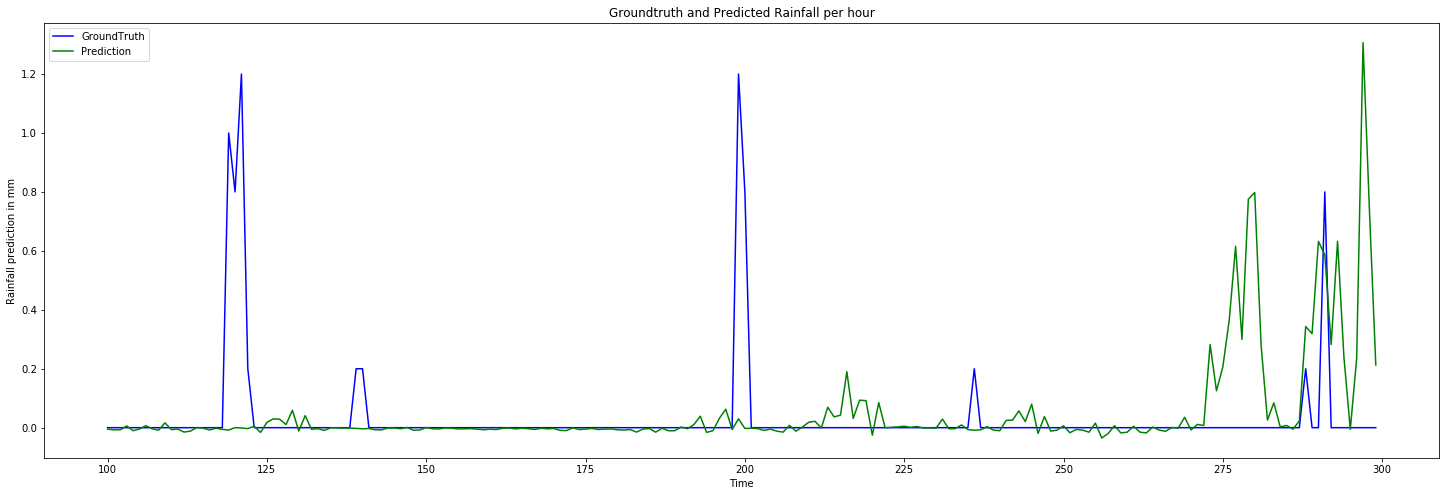

In [29]:
# For plot
time_index = np.arange(0,vec_test.shape[0],1)
time_index = time_index.reshape(((len(time_index),1)))

plt_lower_limit = 100
plt_upper_limit = 300

plt.figure(figsize=(25,8))

# plot

# Full plot
# plt.plot(time_index,vec_test,label="GroundTruth",color='b')
# plt.plot(time_index,pred_vec,label="Prediction",color='g')

# Unpreprocessed Plot
plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_test[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
plt.plot(time_index[plt_lower_limit:plt_upper_limit],pred_vec[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

# Preprocessed Plot
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_test[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],preproc_y[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

plt.xlabel('Time')
plt.ylabel('Rainfall prediction in mm')
plt.legend()
plt.title('Groundtruth and Predicted Rainfall per hour')
# img_filename = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\s7_images\\'+str(test_ex)+'.png'
# plt.savefig(img_filename, bbox_inches='tight')
# plt.clf()

In [30]:
vec_train = y_train.flatten()
vec_train = vec_train.reshape((len(vec_train),1))
print vec_train.shape
print 'total train points: ', vec_train.shape[0]

pred_on_gt = model.predict(x_train)
pred_on_gt_vec = pred_on_gt.flatten()
pred_on_gt_vec = pred_on_gt_vec.reshape((len(pred_on_gt_vec),1))
print pred_on_gt_vec.shape

(2058L, 1L)
total train points:  2058
(2058L, 1L)


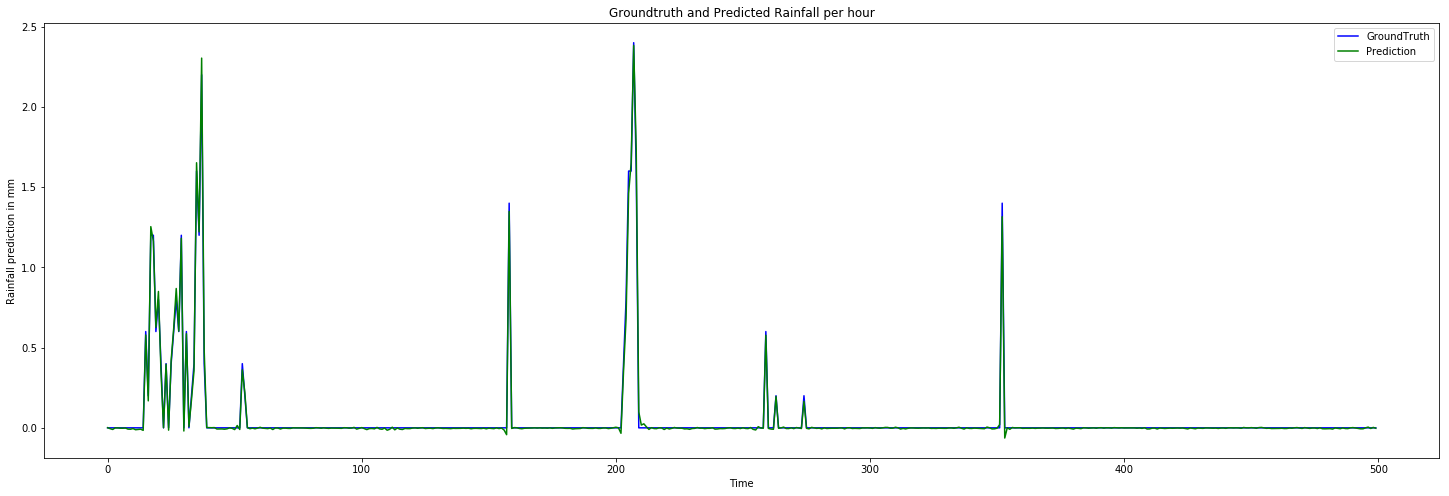

In [31]:
# For plot
time_index = np.arange(0,vec_train.shape[0],1)
time_index = time_index.reshape(((len(time_index),1)))

plt_lower_limit = 0
plt_upper_limit = 500

plt.figure(figsize=(25,8))

# plot

# Full plot
# plt.plot(time_index,vec_test,label="GroundTruth",color='b')
# plt.plot(time_index,pred_vec,label="Prediction",color='g')

# Unpreprocessed Plot
plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_train[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
plt.plot(time_index[plt_lower_limit:plt_upper_limit],pred_on_gt_vec[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

# Preprocessed Plot
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_test[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],preproc_y[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

plt.xlabel('Time')
plt.ylabel('Rainfall prediction in mm')
plt.legend()
plt.title('Groundtruth and Predicted Rainfall per hour')
# img_filename = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\s7_images\\'+str(test_ex)+'.png'
# plt.savefig(img_filename, bbox_inches='tight')
# plt.clf()

In [36]:
model.weights

[lstm_1_W_i,
 lstm_1_U_i,
 lstm_1_b_i,
 lstm_1_W_c,
 lstm_1_U_c,
 lstm_1_b_c,
 lstm_1_W_f,
 lstm_1_U_f,
 lstm_1_b_f,
 lstm_1_W_o,
 lstm_1_U_o,
 lstm_1_b_o,
 lstm_2_W_i,
 lstm_2_U_i,
 lstm_2_b_i,
 lstm_2_W_c,
 lstm_2_U_c,
 lstm_2_b_c,
 lstm_2_W_f,
 lstm_2_U_f,
 lstm_2_b_f,
 lstm_2_W_o,
 lstm_2_U_o,
 lstm_2_b_o,
 lstm_3_W_i,
 lstm_3_U_i,
 lstm_3_b_i,
 lstm_3_W_c,
 lstm_3_U_c,
 lstm_3_b_c,
 lstm_3_W_f,
 lstm_3_U_f,
 lstm_3_b_f,
 lstm_3_W_o,
 lstm_3_U_o,
 lstm_3_b_o,
 lstm_4_W_i,
 lstm_4_U_i,
 lstm_4_b_i,
 lstm_4_W_c,
 lstm_4_U_c,
 lstm_4_b_c,
 lstm_4_W_f,
 lstm_4_U_f,
 lstm_4_b_f,
 lstm_4_W_o,
 lstm_4_U_o,
 lstm_4_b_o,
 dense_1_W,
 dense_1_b]

In [35]:
x_train[1]

array([[ 1.32858621, -0.37289962, -0.13030131, -0.63675583,  1.82585774,
         1.6925565 ,  0.38359335,  0.01441766, -0.2663321 , -0.43865089,
        -0.28675014,  0.22250132,  1.4152999 , -0.17362523, -0.4832482 ,
         0.69036308,  0.6070875 , -1.05759478, -0.28593387, -1.19282626,
        -0.75979541, -0.6369072 , -1.1269686 ],
       [ 1.32858621, -0.37289962, -0.13030131, -0.53022836,  1.82585774,
        -0.52410791, -0.462117  , -0.0748616 , -0.75230864, -0.43865089,
        -0.2605916 ,  0.15773385, -0.69500017, -0.08574428,  0.13629303,
         0.48779138,  0.38742897, -0.89161925, -0.28593387, -1.15622635,
        -0.85664247, -0.18786018, -0.95750808],
       [ 1.32858621, -0.32963586, -0.13030131, -0.44500768,  1.82585774,
        -0.55327454, -0.38283166,  0.03700639, -1.07485942, -0.43865089,
        -0.28675014,  0.26298122,  0.58953031, -0.19096025,  0.54932054,
         0.67995838, -0.6935222 , -0.8362997 , -0.28593387, -1.02406009,
        -1.09582509,  0.1291